# Team 23 - Polynomial Interpolation Project

## Introduction

Our aim is to investigate the problems where each type of interpolation is most useful. Below we set up code to be used throughout:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact, fixed, Layout
from scipy.interpolate import CubicSpline

In [2]:
def f(x):
    return np.exp(x) * np.cos(10 * x)

## Part 1

Part 1 asked us to create a function `piecewiese_interpolation()` which returns the piecewise polynomial interpolated data given a degree, knots and evaluation points. We recognised that part 1 is similar to the problem seen in the lecture “Interpolation Part 3: Piecewise Polynomial” [[1]](https://moody.st-andrews.ac.uk/moodle/pluginfile.php/1535403/mod_resource/content/16/html/3_AppliedNotebooks/Interpolation_Part3_PiecewisePolynomial.html#). 

We worked closely with other members in the team to ensure that arguments had the right types were used in this function, since the function was used for parts 2 and 4, but our first implementation produced clearly inaccurate results. While reviewing the work for part 1, we found that some arguments weren't defined as they should be for later parts. To prevent improper use of the function we adopted a similar approach to checking the function arguments as was already implemented in part 3.

In [3]:
def piecewise_interpolation(deg, x_knots, y_knots, evaluation_points):
    # Check that the arguments are appropriate types / values and raise errors as necessary
    if not isinstance(deg, int):
        raise TypeError(f"deg must be an integer. deg was a {type(deg).__name__}")
    if not isinstance(x_knots, np.ndarray) or not isinstance(y_knots, np.ndarray) or not isinstance(evaluation_points, np.ndarray):
        raise TypeError("x_knots, y_knots, and evaluation_points must all be numpy arrays. Check the arguments used.")
    if deg < 0 or deg >= len(x_knots):
        raise ValueError("deg must be non-negative and strictly less than the number of knots")
    if len(x_knots) != len(y_knots) or x_knots.ndim != 1 or y_knots.ndim != 1 or evaluation_points.ndim != 1:
        raise ValueError(f"x_knots, y_knots, and evaluation_points must all be one dimensional. The lengths of x_knots and y_knots must be equal.")

    # calculates how many interpolants we need to calculate
    no_of_interpolants = len(x_knots) - deg
    # the index of all the points we require to interpolate
    pts = np.arange(deg + 1) + np.arange(no_of_interpolants).reshape(no_of_interpolants, 1)

    # we loop through all the interpolants, run in through the vandermode matrix, and add it to our coeffecients array
    coeff = np.zeros((deg + 1, no_of_interpolants))
    for i in range(no_of_interpolants):
        vander = np.vander(x_knots[pts[i, :]])
        coeff[:, i] = np.linalg.solve(vander, y_knots[pts[i, :]])

    # create necessary arrays for x, y, and the exponents required
    x = evaluation_points
    y = np.empty_like(x)
    pows = (deg) - np.arange(deg + 1)

    # this handles all uneven data points
    for i in range(len(evaluation_points)):  # loop over new evaluation points
        if ((x[i] < x_knots
             ).all()):  # if we're outside of the interval, set k to extrapolate
            k = 0
        elif ((x[i] > x_knots).all()):
            k = len(x_knots) - 1
        else:  # find k for x_i, accounting for the possibility that x_i=x_k
            k = np.where(((x[i] < x_knots[1:]) & (x[i] >= x_knots[:-1])) | ((x_knots[1:] == x[i]) & (x[i] > x_knots[:-1])))[0][0]

        j = k - deg//2
        # account for j<0 or j>Nint-1
        j = np.maximum(0, j)
        j = np.minimum(j, no_of_interpolants - 1)
        # calculate each new data point utilising the coefficients we calculated earlier
        y[i] = np.sum(coeff[:,j]*x[i]**pows)
        
    return y

The following code was provided by the project brief [[2]](https://moody.st-andrews.ac.uk/moodle/pluginfile.php/1577419/mod_resource/content/1/Project1_Description.html), to use for testing and validation.

In [4]:
N = 20
r0 = np.linspace(0, 1 / 6, N)
x1 = 1 / (1 - r0)  # coordinate transformation to test uneven spacing
y1 = f(x1)

Using the unevenly distributed test knots given in the instructions we calculated the maximum absolute error between the exact function and the `piecewise_interpolation` function, and found that this error was appreciably small:

In [5]:
x2 = np.linspace(1, 1.2, N)
y2 = piecewise_interpolation(5, x1, y1, x2)
maxabserr = max(abs(f(x2)-y2))
print(maxabserr)

9.27977161779836e-09


## Part 2

In this part of the project the convergence of `piecewise_interpolation()` was investigated by varying the number of knots that the function runs over. We also compared how convergence changes as we vary the degrees of polynomial used by the interpolation function.

In order to check the convergence of the piecewise interpolation function we must see how the maximum error that the function produces changes as the number of knots, N, increases (ie the usual knot spacing, h, decreases). A ‘nested for loop’ seems suitable for this task as we must iterate through the number of knots, N. However, for each separate N multiple arguments of the function must be varied. We constructed an array with the maximum error, containing appropriate data to create a plot of ‘maximum error-vs-h'. 

In [6]:
# Constants 
a = x1[0]     # start of interval from x1 in part 1
b = x1[-1]    # end of interval from x1 in part 1 
a1 = 1.006    # start of sub-interval
b1 = 1.197    # end of sub-interval
N = 20        # Maximum number of knots tested
M = 30        # Number of evaluation points in the subinterval

# Obtain range of values for h and the evaluation points
N_vals = np.arange(2, N+1) # Gives a range of values for the number of knots 
h = (b - a)/(N_vals - 1)   # Using the given formula to create an array of h values
x_eval = np.linspace(a1, b1, M) # Obtain values for subinterval

# Using a nested for loop to iterate the piecewise interpolation function through the different values of h with different degree of spline
maxError = np.zeros((5, len(h))) #First must create a store for the max error for each value of h
for i in range(4, len(N_vals)): 
    x2 = np.linspace(a, b, N_vals[i]) #will give evenly spaced x-values for the knots in the same interval as x1
    y2 = f(x2) #gives the y-values of the knots
    for j in range(1, 6): #nested loop to iterate through the degrees of polynomial (degree 1 to 5)
        y = piecewise_interpolation(j, x2, y2, x_eval) #Using our interpolation function to with the knot data x2 and y2.
        maxError[j-1,i] = max(abs(f(x_eval) - y))

Choosing the sub-interval and the number of evaluation points within it was critical to the success of this part. Making sure the evaluation points don’t coincide with the knots is important, because otherwise the error at this point would be extremely low and skew the plot in a misleading manner. Similarly, the error close to the knots will be comparatively lower than the error far from them. 

To ensure no coincident points and try to maximise the space between evaluation points and knots, 30 evaluation points were used. To exclude the knots found at the interval limits from the evaluation points, but include all other knots, the subinterval chosen was $[1.006, 1.197]$. To achieve this, the spacing values `h` were chosen so that this issue would not occur. The points were also selected to be comparatively far from the knots.



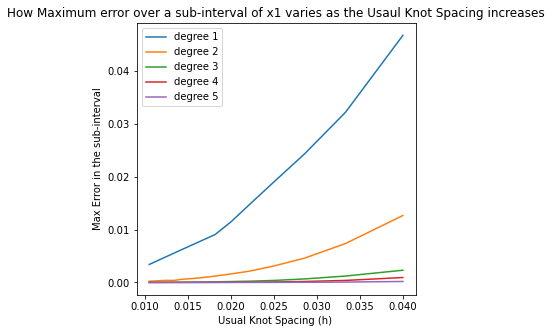

In [7]:
fig, ax1 = plt.subplots(figsize=(5,5))   # A figure in which to plot the errors
for i in range(5):
    ax1.plot(h[4:], maxError[i, 4:] ,label=f'degree {i+1}')
ax1.set_xlabel("Usual Knot Spacing (h) ")
ax1.set_ylabel("Max Error in the sub-interval")
ax1.set_title("How Maximum error over a sub-interval of x1 varies as the Usaul Knot Spacing increases")
ax1.legend();

From the plot above, it is clear to see that as the spacing between the knots increases so does the maximum error associated with each individual value of knot spacing. Furthermore, the magnitude of the maximum error decreases significantly as the degree of the polynomial being used in the interpolation function increases. 

Both trends are to be expected. As the knot spacing decreases the number of knots will be larger, this will give the function more data to work with and it will be able to produce more accurate values. Likewise, when the degree of the polynomial used in the interpolation function increases, so do the degrees of freedom of the curves fitting to the data. This results in a greater ability to represent complex data curves. We note that as the data curve the function is approximating is the same  for all the fits, the higher degree polynomials produce a more accurate fit, hence lower error.  

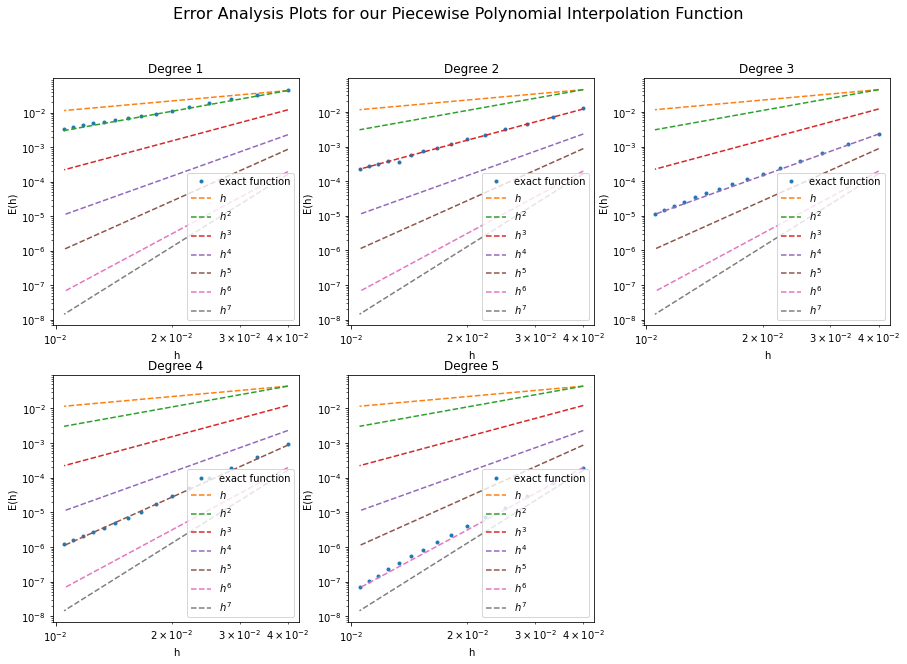

In [7]:
# Analysis of error
fig, ays = plt.subplots(ncols=3, nrows=2,figsize=(15, 10))
fig.suptitle('Error Analysis Plots for our Piecewise Polynomial Interpolation Function' , fontsize=16) # Plots of maximum error for different degrees, alongside different exponents of h
fig.delaxes(ays[1,2])
ayes = [ays[0,0],ays[0,1],ays[0,2],ays[1,0],ays[1,1]]

# a loop to plot the maximum error for each polynomial degree on different subplots
i = 0
for ays in ayes:
    ays.set_title(f"Degree {i+1}");
    # use of log-log plot to build a bigger picture and see smaller details of the trend on the graph.
    # Also, we are interested in different exponents of h, so a log-log graph allows a better view of the trends for these.
    # loglog() from reference to [3], specifically the application example
    ays.loglog((h[4:]),maxError[i, 4:],'.',label='exact function')
    ays.loglog((h[4:]),1.1*(h[4:]),'--',label='$h$')
    ays.loglog((h[4:]),27.5*(h[4:])**2,'--',label='$h^2$')
    ays.loglog((h[4:]),190*(h[4:])**3,'--',label='$h^3$')
    ays.loglog((h[4:]),900*(h[4:])**4,'--',label='$h^4$')
    ays.loglog((h[4:]),8500*(h[4:])**5,'--',label='$h^5$')
    ays.loglog((h[4:]),48000*(h[4:])**6,'--',label='$h^6$')
    ays.loglog((h[4:]),1000000*(h[4:])**7,'--',label='$h^7$')
    ays.set_xlabel('h')
    ays.set_ylabel('E(h)')
    ays.legend();
    i = i+1

When producing the above plots, there was flexibility in the coefficients of $h$,$h^2$,...,$h^7$. The coefficients only vary the y-intercepts of the lines, and not the gradients (which is what we are comparing to the maximum error for each degree). For clarity, we altered the coefficients to fit the lines as closely as possible to the error. We can see which exponent of $h$ correlates with our line for maximum error for the function in the polynomial of that degree.

**Polynomial Degree One**:
We can see that our line of maximum error for our interpolation for polynomials of degree one follows most closely to the line $h^2$. The trend of the error in our function for polynomials degree 1 therefore is proportional to $h^2$, where $h$ is the spacing between knots. Therefore if we were to half the spacing of knots, we would quarter the error in our approximation.

**Polynomial Degree Two, Three, Four, Five**:
Following similarly to the polynomials of degree one, the maximum error for our interpolation for polynomials of degree 2 follows closest to and is proportional to the line $h^3$, 3 follows closest to the line $h^4$, degree 4 to the line $h^5$, and degree 5 to the line $h^6$.

**Overall Trends and Conclusion**:
We observe that when looking at the polynomial of degree $n$, we can expect that the trend of error in our function will be proportional to $h^{(n+1)}$. Therefore, when scaling the spacing of knots by $\frac{1}{k}$ we can expect to have $\frac{1}{k^{(n+1)}}$th of the error, where $n$ is the degree of polynomial. For example, if we half the spacing of knots for a polynomial of degree $n$, we will have $\frac{1}{2^{(n+1)}}$ of the error in our approximation.


## Part 3

We investigated how varying the degree of a Lagrange interpolating polynomial for a fixed knots changes the result of the interpolation, by creating an interactive plot. This is of interest because increasing the degree of the polynomial requires solving a more complex system to find the coefficients. However, we also expect it to improve the fit of the interpolant. Understanding this variation, therefore, allows us to find a good balance between these factors when solving other problems.

Since the interest of this problem is how well the interpolant fits the data, we also plotted the error alongside the function and the interpolant in a separate subplot, so that points can be easily compared across the two plots.

To create an interactive plot, we referred to the core course notes (ch. 2 Interactivity) [[4]](https://moody.st-andrews.ac.uk/moodle/pluginfile.php/1535403/mod_resource/content/16/html/2_CoreNotebooks/2Interactivity.html) and the documentation linked therein [[5]](https://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html). Based on this, we wrote a function (`plot_lagrange_poly()`) which produced the desired plot where the degree of said interpolant was an argument (`degree`), and then used `interact()` from `ipywidgets` to allow the user to vary `degree`.

Because the knots available for the interpolant do not change, we needed to select the relevant knots at each degree from the middle of the interval. We achieved this by calculating `I`, the index of the first used knot, based on both `degree` and `degmax`.

In the course of testing the function, we also tested its behaviour when passed arguments that should not be allowed. Since `I` takes a value based on `degmax - degree`, choosing `degree` > `degmax` resulted in `I` being negative. When `I` was then used as an index for array `x`, it was therefore interpreted as indexing back from the end of the array. This made the plot appear to function normally but produced incorrect results, which would be misleading.

We referred to the MT2505 computing project notes [[6]](https://moody.st-andrews.ac.uk/moodle/pluginfile.php/1388768/mod_resource/content/1/MT2505%20Project%20-%20Part%202%20Solutions.html) for how to raise a `ValueError` at the start of the function if this occurred. We extended this section to test other possible problems with these arguments, restricting them to being non-negative integers (a requirement for the degree of a polynomial). Having investigated the raising of errors, we then applied this knowledge to other parts of the project, particularly part 1. 

In [8]:
def plot_lagrange_poly(degree, g, degmax):
    # Raise errors if degree or degmax are not given appropriate values
    if not isinstance(degree, int) or not isinstance(degmax, int):
        raise TypeError(f"degree and degmax must both be integers. degree was a {type(degree).__name__} and degmax was a {type(degmax).__name__}")
    if degree < 0 or degmax < 0 or degree > degmax:
        raise ValueError("degree and degmax must both be non-negative. degree must not be greater than degmax.")
    
    # Determine the number of knots, evaluation points, and knot values
    N = degmax + 1  # maximum available knots
    M = degree + 1  # number of knots to use
    x = np.linspace(1, 2, N)
    y = g(x)
    t = np.linspace(1, 2, 100) # points to plot interpolant
    I = int((N-M) / 2) # number of knots to omit before the interpolant
    
    # Compute the Vandermonde matrix and solve the system of equations to obtain the coefficients of the interpolating polynomial
    V = np.vander(x[I:I+M] , increasing=True)
    coeffs = np.linalg.solve(V, y[I:I+M])
    # Evaluate the polynomial over the interval using np.polyval and calculate the absolute error at each evaluated point
    interpolant = np.polyval(coeffs[::-1], t)
    error = abs(g(t) - interpolant)
    
    # Find appropriate fixed limits for each plot, to make comparing plots as the degree varies easier
    glims = np.array([g(t)[np.argmin(g(t))] , g(t)[np.argmax(g(t))]])
    grange = glims[1] - glims[0]
    plotlims = np.array([glims[0] - 0.1*grange , glims[1] + 0.1*grange])
    errorlims = np.array([-grange/8 , grange - grange/8])
    
    # Plot the interpolating polynomial and the set of knots
    fig = plt.figure(figsize=(16, 6))
    ax = fig.add_subplot(121)
    ax.plot(t, g(t), label="True function")
    ax.plot(t, interpolant, label='Lagrange polynomial')
    ax.plot(x, y, 'X', label='Knots', color = 'k')
    ax.set_xlabel('x', fontsize = 12)
    ax.set_ylabel('f(x)', fontsize = 12)
    ax.set_xlim([0.95, 2.05])
    ax.set_ylim(plotlims)
    ax.set_title(f"Lagrange polynomial of degree {degree}", fontsize = 14)
    ax.legend(loc = 3)
    
    # Plot the error between the interpolating polynomial and the true function
    ax2 = fig.add_subplot(122)
    ax2.plot(t, error, label="Absolute error")
    ax2.axhline(0, linewidth = 1, color = 'k', zorder = 0)
    ax2.set_xlabel('x', fontsize = 12)
    ax2.set_ylabel('absolute error', fontsize = 12)
    ax2.set_xlim([0.95, 2.05])
    ax2.set_ylim(errorlims)
    ax2.set_title(f"Error in lagrange polynomial of degree {degree}", fontsize = 14)
    # plt.text() from reference to [7]
    # np.around() from reference to [8]
    ax2.text(0.98, 3*errorlims[0]/5, f"maximum error = {np.around(error[np.argmax(error)], 5)}", fontsize = 12)
    
# Apply interactivity
interact(plot_lagrange_poly, degree=(1, 10), g=fixed(f), degmax=fixed(10));

interactive(children=(IntSlider(value=5, description='degree', max=10, min=1), Output()), _dom_classes=('widge…

We observe that the interpolants of higher degree generally provide a better fit than those of low degree. This result is expected, since as the interpolant degree increases, so does the quantity of known data used. We also observe that the error is larger at the edges of the interval. This is also expected - the function chooses knots from the middle of the interval first, then works outwards. Therefore, the interpolant first approximates the middle of the interval, and then improves the fit nearer the edges as it increases in degree.

The variation of the maximum error is less consistent. This behavior seems unexpected, but is a result of the gradients of such curves. The cubic interpolant approximates the data function well for an  larger range of x values than the linear interpolant, but also has an increasing (absolute) gradient at the edges. It grows away from the data function much faster than the linear one, leading to the larger maximum error. This effect is reduces as the degree increases, as knots nearer the edges of the interval restrict this growth.

## Part 4

Throughout this part, the primary goal was to compare our own `piecewise_interpolation` function and the 
`CubicSpline` function provided by SciPy using the data provided in `wave_data1.txt`.

We are interested in this comparison as the `CubicSpline` is known to produce a good approximation when interpolating over data, as discussed in the lecture course [[9]](https://moody.st-andrews.ac.uk/moodle/pluginfile.php/1535403/mod_resource/content/16/html/3_AppliedNotebooks/Interpolation_Part4_CubicSpline.html). It therefore acts as a good baseline against which to judge the performance of our piecewise polynomial interpolation function.

In [9]:
# load the given data from txt file
filepath = "wave_data1.txt"
data = np.loadtxt(filepath)

OSError: wave_data1.txt not found.

When inspecting the `wave_data1.txt` data, we observed that the data was collected over 30s with a typical step size of 0.1s. As such, assuming no gaps we would expect 300 pieces of data. From this we calculated that there are 8 data points missing, as follows:

In [10]:
num_missing = 300 - len(data[0])

NameError: name 'data' is not defined

Here, we created a new set of data. We started by creating an interval from 0 to 20 with 0.01s step size as requested in the project brief. Then we applied both our own `piecewise_interpolation` with a set degree 3 to produce cubic polynomials and use the t and ξ values as `x_knots` and `y_knots`. Finally, we created a cubic spline function for comparision and applied it to the same interval.

In [12]:
# create the range of data points we are interested in, np.arange() from reference to [10]
x_alt = np.arange(0,20,0.01) 

# evaluate data points using our piecewise interpolation function
y_pi = piecewise_interpolation(3, data[0],data[1], x_alt)

# create a cubic spline based on data from file
cs = CubicSpline(data[0],data[1])
y_cs = cs(x_alt)

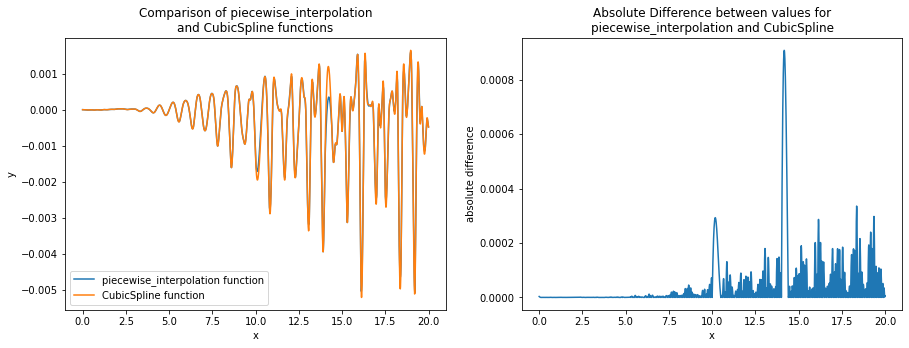

In [13]:
fig = plt.figure(figsize=(15, 5))

# plot the two functions on one figure
ax1 = fig.add_subplot(121)
ax1.plot(x_alt,y_pi, label='piecewise_interpolation function')
ax1.plot(x_alt,y_cs, label='CubicSpline function')
ax1.set_title("""Comparison of piecewise_interpolation
and CubicSpline functions""")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.legend()

# plot the absolute error between the two methods
ax2 = fig.add_subplot(122)
ax2.plot(x_alt,abs(y_cs-y_pi))
ax2.set_title("""Absolute Difference between values for
piecewise_interpolation and CubicSpline""")
ax2.set_xlabel("x")
ax2.set_ylabel("absolute difference")

fig.show()

The results we achieved show that `piecewise_interpolation()` gives us a good approximation. When plotted, there are two noticeable areas where our piecewise interpolation function and SciPy's `CubicSpline()` function disagree (discussed below).

Looking at the graph depicting the absolute difference between the two functions shows that there is almost no error between the approxinations for the first $7.5s$ of data. We also observe that away from the two most extreme deviations, there is still error between the approximations. This is expected, since they use different methods of construction.

In [14]:
print("Areas of Missing Data:")
for i in range(len(data[0]) - 1):
    # if the difference between two data points is greater than 0.1 then there is a gap in the data
    if (data[0][i+1] - data[0][i] - 0.1) > 10**-5:
        print("Between " + str(data[0][i]) + " and " + str(data[0][i+1]))

Areas of Missing Data:
Between 2.3 and 2.5
Between 9.999999999999998 and 10.499999999999998
Between 13.999999999999998 and 14.399999999999999


The spikes in error we obtain can be explained after some analysis of the provided data (see cell above). The code above reveals that there are some large gaps, particularly at $14.0s-14.4s$. This is reflected in our absolute difference graph where the largest spike comes from that range. It is reasonable to assume that this lack of data caused this inaccuracy, but it is impossible from our results alone to say whether our `piecewise_interpolation` function was not as effective at handling unevenly spaced data as `CubicSpline`, only that they differ in their output.

## Who Did What

- **Daniyal Bilal**
Main code for part 1, minor edits in report for part 1
- **James Conn**
Report introduction, report for part 1, supporting code for part 1
- **James Farnell**
Nominated project coordinator (integrating code versions), debugging/error handling for part 1, code and report for part 4
- **Jamie Macmillan**
Initial code for part 3, report for part 3
- **John Paterson**
Initial investigation code for part 2, report for part 2
- **Remy Smith**
Debugging/error handling for part 1, code modifications for part 3, report for part 3
- **Siobhan Williams**
Error analysis code for part 2, report for part 2

## References

[1] - Lucas, D., Smith, F. and Swallow B., 2022. Interpolation Part 3: Piecewise polynomial interpolation [Online]. Available at https://moody.st-andrews.ac.uk/moodle/pluginfile.php/1535403/mod_resource/content/16/html/3_AppliedNotebooks/Interpolation_Part3_PiecewisePolynomial.html# [accessed 24/2/23]

[2] - teachinghub.st-andrews.ac.uk, 2022/23. Applied Mathematics Team Project. Sem 2, 2022/23 [Online]. Available at https://moody.st-andrews.ac.uk/moodle/pluginfile.php/1577419/mod_resource/content/1/Project1_Description.html [accessed 22/2/23-9/3/23]

[3] - Lucas, D., Smith, F. and Swallow B., 2022. Interpolation Part 1: Linear Interpolation [Online]. Available at https://moody.st-andrews.ac.uk/moodle/pluginfile.php/1535403/mod_resource/content/17/html/3_AppliedNotebooks/Interpolation_Part1_Linear.html [accessed 02/03/2023]

[4] - Lucas, D., Smith, F. and Swallow B., 2022. Interactivity [Online]. Available at https://moody.st-andrews.ac.uk/moodle/pluginfile.php/1535403/mod_resource/content/16/html/2_CoreNotebooks/2Interactivity.html [accessed 23/2/23]

[5] - Project Jupyter, no date. Using Interact [Online]. Available at https://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html [accessed 23/2/23]

[6] - moody.st-andrews.ac.uk, 2021/22. MT2505 Computing Project Part 1 (Semester 2 2021/22) [Online]. Available at https://moody.st-andrews.ac.uk/moodle/pluginfile.php/1388768/mod_resource/content/1/MT2505%20Project%20-%20Part%202%20Solutions.html [accessed 23/2/23]

[7] - The Matplotlib development team, no date. matplotlib.pyplot.text [Online]. Available at https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.text.html [accessed 26/2/23]

[8] - NumPy Developers, no date. numpy.around [Online]. Available at https://numpy.org/doc/stable/reference/generated/numpy.around.html [accessed 26/2/23]

[9] - Lucas, D., Smith, F. and Swallow B., 2022. Interpolation Part 4: Spline interpolation [Online]. Available at https://moody.st-andrews.ac.uk/moodle/pluginfile.php/1535403/mod_resource/content/16/html/3_AppliedNotebooks/Interpolation_Part4_CubicSpline.html [accessed 5/3/23]

[10] - NumPy Developers, no date. numpy.arange [Online]. Available at https://numpy.org/doc/stable/reference/generated/numpy.arange.html [accessed 26/3/23]